# 1006개의 데이터로 Transfer_Learning 하기

- 논문의 모델에 1006개의 데이터를 넣고 학습을 시켜보자

## Step 1. 실험환경 set-up

#### 라이브러리 실행

In [1]:
from tensorflow.keras.models import Sequential, load_model

import os           
import numpy             as np  
import tensorflow        as tf
import matplotlib.pyplot as plt

#### 필요한 변수들 생성

In [2]:
IMAGE_SIZE = [1024, 1360]                  # 이미지 사이즈 변수
BATCH_SIZE = 32                            # BATCH_SIZE 변수
EPOCHS     = 150                           # EPOCH 크기 변수
AUTOTUNE   = tf.data.experimental.AUTOTUNE # 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수

#### GPU 사용 여부보기

In [3]:
gpus = tf.config.experimental.list_logical_devices("GPU")

if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print(f"Running on multiple GPUs {[gpu.name for gpu in gpus]}")

elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print(f"Running on single GPU {gpus[0].name}")

else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print(f"Number of accelerators: {strategy.num_replicas_in_sync}")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Step 2. 데이터 준비하기

먼저 아래의 링크에서 데이터를 다운 받을 것

https://drive.google.com/drive/folders/1Pi5qyX080zY2IdGT1TvvLraBO9DHBxJl?usp=sharing

받은 후 터미널 창에 아래의 명령어들을 차례로 입력

```
$ cd ~/Downloads && cp CellPin ~/aiffel
```

#### 데이터의 개수 확인

In [4]:
# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv("HOME"), "aiffel/CellPin")
print(ROOT_PATH)

# 각 데이터 불러오기
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + "/train/*/*"))
test_filenames  = tf.io.gfile.glob(str(ROOT_PATH + "/test/*/*"))
val_filenames   = tf.io.gfile.glob(str(ROOT_PATH + "/val/*/*"))

# 데이터 갯수 확인하기
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

/home/mochafreddo/cellpin/CellPin
782
104
126


#### train 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in train_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 355
CPE images count in training set: 427


#### val 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [7]:
COUNT_NORMAL = len([filename for filename in val_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in val_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 50
CPE images count in training set: 76


#### test 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [8]:
COUNT_NORMAL = len([filename for filename in test_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in test_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 40
CPE images count in training set: 64


#### tf.data 인스턴스를 만들기

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds   = tf.data.Dataset.from_tensor_slices(val_filenames)

#### train data와 val data의 개수 확인

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 782
Validating images count: 126


#### 라벨 이름들 확인

In [11]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/train/*"))])
print(CLASS_NAMES)

['normal' 'cpe']


#### 라벨링 함수를 만들어 보기

In [12]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "cpe"

#### decode_img 함수와 process_path 함수를 만들기

In [13]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels = 1)
    
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
    
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    
    if label == True:
        label = ([0, 1])
    else:
        label = ([1, 0])
        
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    
    return img, label

#### train과 val에 함수들 적용해주기

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds   = val_list_ds.map(process_path,   num_parallel_calls = AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


#### 전처리 함수 만들기 및 적용

In [16]:
def prepare_for_training(ds, shuffle_buffer_size = 1000):
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = AUTOTUNE)

    return ds


train_ds = prepare_for_training(train_ds)
val_ds   = prepare_for_training(val_ds)

#### Image shape를 변경 체크하기

In [17]:
for image, label in train_ds.take(1):
    print("Image shape :", image.numpy().shape)
    print("Label :",       label.numpy().shape)

Image shape:  (32, 1024, 1360, 1)
Label:  (32, 2)


#### test 데이터 셋도 만들어 보기 & 데이터의 갯수 확인

In [18]:
test_list_ds     = tf.data.Dataset.list_files(str(ROOT_PATH + "/test/*/*"))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds          = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds          = test_ds.batch(BATCH_SIZE)
print(TEST_IMAGE_COUNT)

104


## Step 3. 데이터 시각화

#### 16개의 샘플 꺼내서 확인

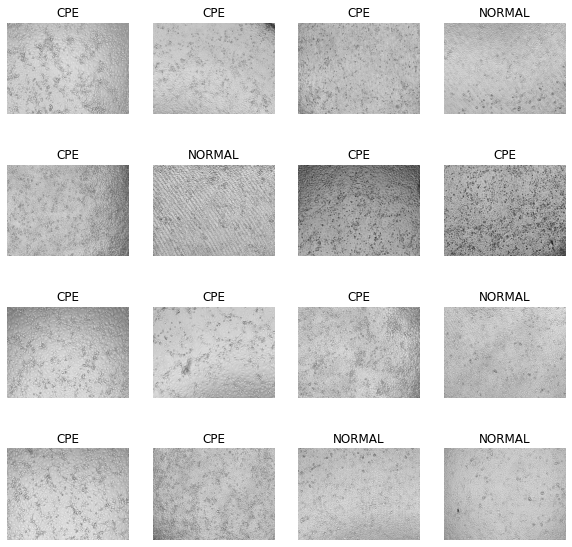

In [19]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10,10))
    
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n])
        
        if list(label_batch[n])[0].numpy() == 0:
            plt.title("CPE")
        else:
            plt.title("NORMAL")
        
        plt.axis("off")

        
show_batch(image_batch.numpy(), label_batch)

#### model building(basemodel, Freeze)

In [ ]:
with strategy.scope():
    # 기존 논문의 모델을 불러오기
    model = load_model(ROOT_PATH + "/pre_training_model/0816_influ_filter_model_1")
    
    # 기존 모델에서 Freeze 할 레이어 선택하기
    temp_model = model.layers[:-9]

    # layer freeze
    for n, i in enumerate(temp_model):
        i.trainable = False
        
    # fc_layer 만들기
    fc_layer = [
        Flatten(),
    
        Dense(100),
        Activation("relu"),
    
        Dense(100, kernel_constraint= MaxNorm(1.)),
        Activation("relu"),
    
        Dense(100, kernel_regularizer=regularizers.l2(0.01)),
        Activation("relu"),
 
        Dense(2),
        Activation("softmax")
    ]
    
    # 모델 빌드
    new_model = tf.keras.Sequential(temp_model + fc_layer)

## Step 4. 모델 훈련

#### GPU사용하여 model complie

In [29]:
with strategy.scope():
    METRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name    = "recall")
    ]
    
    new_model.compile(
        optimizer = "adam",
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
    
    check_point = tf.keras.callbacks.ModelCheckpoint("Paper_Model_Freeze.h5")

In [30]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv_layer (Conv2D)    (None, 1018, 1354, 20)    1000      
_________________________________________________________________
activation_1 (Activation)    (None, 1018, 1354, 20)    0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 101, 135, 20)      0         
_________________________________________________________________
second_conv_layer (Conv2D)   (None, 97, 131, 25)       12525     
_________________________________________________________________
activation_2 (Activation)    (None, 97, 131, 25)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 21, 25)        0         
_________________________________________________________________
third_conv_layer (Conv2D)    (None, 14, 19, 30)       

#### 모델 fitting

In [31]:
history = new_model.fit(
    train_ds,
    steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs           = EPOCHS,
    validation_data  = val_ds,
    validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
    callbacks        = [check_point]
)

Epoch 1/150
24/24 [==============================] - 24s 572ms/step - loss: 1.6033 - accuracy: 0.6215 - precision: 0.6215 - recall: 0.6215 - val_loss: 1.3089 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 0.6250
Epoch 2/150
24/24 [==============================] - 11s 486ms/step - loss: 1.2358 - accuracy: 0.6104 - precision: 0.6104 - recall: 0.6104 - val_loss: 0.9975 - val_accuracy: 0.7188 - val_precision: 0.7188 - val_recall: 0.7188
Epoch 3/150
24/24 [==============================] - 11s 458ms/step - loss: 0.8999 - accuracy: 0.8257 - precision: 0.8257 - recall: 0.8257 - val_loss: 0.7492 - val_accuracy: 0.7708 - val_precision: 0.7708 - val_recall: 0.7708
Epoch 4/150
24/24 [==============================] - 11s 459ms/step - loss: 0.6661 - accuracy: 0.8317 - precision: 0.8317 - recall: 0.8317 - val_loss: 0.6099 - val_accuracy: 0.8021 - val_precision: 0.8021 - val_recall: 0.8021
Epoch 5/150
24/24 [==============================] - 11s 465ms/step - loss: 0.5446 - accuracy: 0

24/24 [==============================] - 9s 388ms/step - loss: 0.2160 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - val_loss: 0.3905 - val_accuracy: 0.8646 - val_precision: 0.8646 - val_recall: 0.8646
Epoch 74/150
24/24 [==============================] - 9s 390ms/step - loss: 0.2191 - accuracy: 0.9190 - precision: 0.9190 - recall: 0.9190 - val_loss: 0.3499 - val_accuracy: 0.8646 - val_precision: 0.8646 - val_recall: 0.8646
Epoch 75/150
24/24 [==============================] - 9s 390ms/step - loss: 0.2348 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - val_loss: 0.3952 - val_accuracy: 0.8333 - val_precision: 0.8333 - val_recall: 0.8333
Epoch 76/150
24/24 [==============================] - 9s 387ms/step - loss: 0.2062 - accuracy: 0.9192 - precision: 0.9192 - recall: 0.9192 - val_loss: 0.3684 - val_accuracy: 0.8646 - val_precision: 0.8646 - val_recall: 0.8646
Epoch 77/150
24/24 [==============================] - 9s 390ms/step - loss: 0.1939 - accuracy: 0.9265 - preci

24/24 [==============================] - 9s 364ms/step - loss: 0.2298 - accuracy: 0.8943 - precision: 0.8943 - recall: 0.8943 - val_loss: 0.3093 - val_accuracy: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062
Epoch 146/150
24/24 [==============================] - 9s 387ms/step - loss: 0.1548 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - val_loss: 0.4349 - val_accuracy: 0.8646 - val_precision: 0.8646 - val_recall: 0.8646
Epoch 147/150
24/24 [==============================] - 9s 385ms/step - loss: 0.1541 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - val_loss: 0.3911 - val_accuracy: 0.8854 - val_precision: 0.8854 - val_recall: 0.8854
Epoch 148/150
24/24 [==============================] - 9s 376ms/step - loss: 0.1669 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - val_loss: 0.3004 - val_accuracy: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062
Epoch 149/150
24/24 [==============================] - 9s 377ms/step - loss: 0.1449 - accuracy: 0.9389 - p

## Step 5. 결과 확인 및 시각화

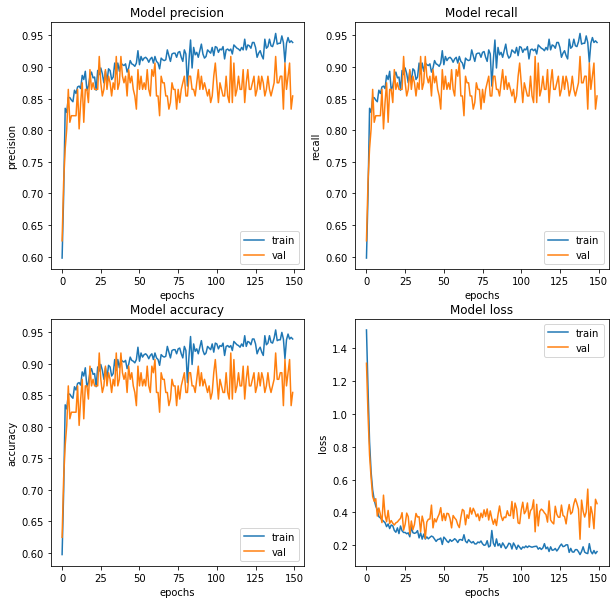

In [32]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

## Step 6. 최종 Test dataset 검정하기

In [33]:
with strategy.scope():
    model = tf.keras.models.load_model("Paper_Model_Freeze.h5")
    
    loss, acc, prec, rec = model.evaluate(test_ds)

4/4 [==============================] - 1s 97ms/step - loss: 0.3055 - accuracy: 0.8654 - precision: 0.8654 - recall: 0.8654


## Step 7. Fine Tunning

In [34]:
for n, i in enumerate(temp_model):  # = model.layers로 하였을 때에도 가능
    i.trainable = True
    print(f"number : {n}, trainable : {i.trainable}")

number : 0, trainable : True
number : 1, trainable : True
number : 2, trainable : True
number : 3, trainable : True
number : 4, trainable : True
number : 5, trainable : True
number : 6, trainable : True
number : 7, trainable : True
number : 8, trainable : True


In [37]:
fc_layer = model.layers[9:]

In [38]:
final_model = tf.keras.Sequential(temp_model + fc_layer)

In [39]:
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv_layer (Conv2D)    (None, 1018, 1354, 20)    1000      
_________________________________________________________________
activation_1 (Activation)    (None, 1018, 1354, 20)    0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 101, 135, 20)      0         
_________________________________________________________________
second_conv_layer (Conv2D)   (None, 97, 131, 25)       12525     
_________________________________________________________________
activation_2 (Activation)    (None, 97, 131, 25)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 21, 25)        0         
_________________________________________________________________
third_conv_layer (Conv2D)    (None, 14, 19, 30)       

In [40]:
with strategy.scope():
    METRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name    = "recall")
    ]
    
    vgg19.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
    
    check_point = tf.keras.callbacks.ModelCheckpoint("Paper_Model_Final.h5")

In [41]:
with strategy.scope():
    history = final_model.fit(
        train_ds,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [check_point]
    )

Epoch 1/150
24/24 [==============================] - 19s 473ms/step - loss: 2.6931 - accuracy: 0.5747 - precision: 0.5747 - recall: 0.5747 - val_loss: 0.6812 - val_accuracy: 0.5625 - val_precision: 0.5625 - val_recall: 0.5625
Epoch 2/150
24/24 [==============================] - 11s 464ms/step - loss: 0.6993 - accuracy: 0.5357 - precision: 0.5357 - recall: 0.5357 - val_loss: 0.6786 - val_accuracy: 0.5938 - val_precision: 0.5938 - val_recall: 0.5938
Epoch 3/150
24/24 [==============================] - 11s 473ms/step - loss: 0.6825 - accuracy: 0.5983 - precision: 0.5983 - recall: 0.5983 - val_loss: 0.6896 - val_accuracy: 0.5521 - val_precision: 0.5521 - val_recall: 0.5521
Epoch 4/150
24/24 [==============================] - 11s 472ms/step - loss: 0.6947 - accuracy: 0.5474 - precision: 0.5474 - recall: 0.5474 - val_loss: 0.6967 - val_accuracy: 0.5208 - val_precision: 0.5208 - val_recall: 0.5208
Epoch 5/150
24/24 [==============================] - 11s 464ms/step - loss: 0.6954 - accuracy: 0

24/24 [==============================] - 11s 471ms/step - loss: 0.3268 - accuracy: 0.8683 - precision: 0.8683 - recall: 0.8683 - val_loss: 0.3828 - val_accuracy: 0.8229 - val_precision: 0.8229 - val_recall: 0.8229
Epoch 74/150
24/24 [==============================] - 11s 464ms/step - loss: 0.3578 - accuracy: 0.8346 - precision: 0.8346 - recall: 0.8346 - val_loss: 0.5731 - val_accuracy: 0.7812 - val_precision: 0.7812 - val_recall: 0.7812
Epoch 75/150
24/24 [==============================] - 11s 483ms/step - loss: 0.3845 - accuracy: 0.8536 - precision: 0.8536 - recall: 0.8536 - val_loss: 0.3463 - val_accuracy: 0.8229 - val_precision: 0.8229 - val_recall: 0.8229
Epoch 76/150
24/24 [==============================] - 11s 461ms/step - loss: 0.3030 - accuracy: 0.8544 - precision: 0.8544 - recall: 0.8544 - val_loss: 0.4783 - val_accuracy: 0.8229 - val_precision: 0.8229 - val_recall: 0.8229
Epoch 77/150
24/24 [==============================] - 11s 462ms/step - loss: 0.3628 - accuracy: 0.8215 - 

Epoch 145/150
24/24 [==============================] - 11s 472ms/step - loss: 0.2280 - accuracy: 0.9164 - precision: 0.9164 - recall: 0.9164 - val_loss: 0.3537 - val_accuracy: 0.8229 - val_precision: 0.8229 - val_recall: 0.8229
Epoch 146/150
24/24 [==============================] - 11s 472ms/step - loss: 0.2192 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - val_loss: 0.3335 - val_accuracy: 0.8542 - val_precision: 0.8542 - val_recall: 0.8542
Epoch 147/150
24/24 [==============================] - 11s 459ms/step - loss: 0.1765 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - val_loss: 0.3731 - val_accuracy: 0.8542 - val_precision: 0.8542 - val_recall: 0.8542
Epoch 148/150
24/24 [==============================] - 11s 463ms/step - loss: 0.1965 - accuracy: 0.9203 - precision: 0.9203 - recall: 0.9203 - val_loss: 0.4132 - val_accuracy: 0.8333 - val_precision: 0.8333 - val_recall: 0.8333
Epoch 149/150
24/24 [==============================] - 11s 461ms/step - loss: 0.1526 - a

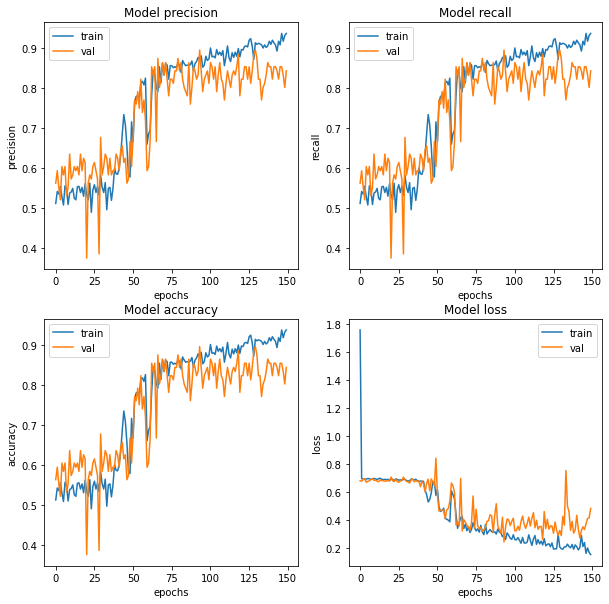

In [42]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [43]:
with strategy.scope():
    model = tf.keras.models.load_model("Paper_Model_Final.h5")
    
    loss, acc, prec, rec = model.evaluate(test_ds)

4/4 [==============================] - 1s 75ms/step - loss: 0.4175 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750
